In [445]:
import os
import sys
import pandas as pd
sys.path.insert(0, os.path.abspath('../lib'))

import config
import librosa
import librosa.display


import numpy as np
import random

from random import random

# Troubleshooting and visualisation
import IPython.display as ipd
from IPython.display import Audio 
from IPython.display import display
import matplotlib.pyplot as plt

In [446]:

df = pd.read_csv("/Users/sannikilpelainen/HumBugDB/data/metadata/neurips_2021_zenodo_0_0_1.csv")
idx_female_eaten = np.logical_and(df['gender'] == 'Female', df['fed'] == 't')
idx_female_uneaten = np.logical_and(df['gender'] == 'Female', df['fed'] == 'f')
idx_male_all = np.logical_and(df['gender'] == 'Male', df['fed'].all())

idx_all = idx_male_all + idx_female_eaten + idx_female_uneaten


In [447]:
def select_hungry(status):
    if status == 't':
        return 1
    elif status == 'f':
        return 0
    else:
        return 1
    
def choose_mosquitos(status):
    # if status is 'f', pick or don't pick with probability 1/8
    # otherwise pick with probability 1

    if status == 'f':
        random = np.random.random()
        if random < 0.125:
            return True
        return False    
    return True 


df_all = df.to_numpy()
not_for_blood = []
mosquitoes = []
for idx in range(len(idx_all)):
    if idx_all[idx] == True:
        fed_status = df_all[idx, 8]
        if not choose_mosquitos(fed_status):
            continue
        new_fed_status = select_hungry(fed_status)
        df_all[idx, 8] = new_fed_status
        mosquitoes.append(df_all[idx, :])

df_mosquitoes = pd.DataFrame(mosquitoes, columns=df.columns)
df_mosquitoes.head()

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
0,107,0.312049,CDC_Ae-albopictus_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae albopictus,Male,1,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
1,125,0.273840,CDC_Ae-albopictus_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae albopictus,Male,1,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,132,0.388470,CDC_Ae-albopictus_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae albopictus,Male,1,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,134,0.312049,CDC_Ae-albopictus_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae albopictus,Male,1,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,146,0.757834,CDC_Ae-albopictus_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae albopictus,Male,1,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture


In [448]:
def match_file(sample_number, rate=8000):
    folder_number = 0
    while folder_number < 5:
        try:
            filename = f"/Users/sannikilpelainen/Downloads/humbugdb_neurips_2021_{folder_number}/{sample_number}.wav"
            return librosa.load(filename, sr=rate)
        except FileNotFoundError:
            folder_number += 1
            continue


In [449]:
def create_data(signal, rate, sample_number, mosquito):
    gender = mosquito[7]
    fed = mosquito[8]
    device = mosquito[12]
    data = [sample_number, fed, gender, device, rate, signal.flatten()]
    return data

In [450]:
def get_fft_signal(signal):
    # filter with high pass filter
    D = librosa.stft(signal)  # STFT of y
    return np.abs(D)

/var/folders/_f/73d70ysn2hxd43fg10gy9r3h0000gn/T/ipykernel_92078/789553557.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  return librosa.load(filename, sr=rate)
/Users/sannikilpelainen/Library/Python/3.10/lib/python/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


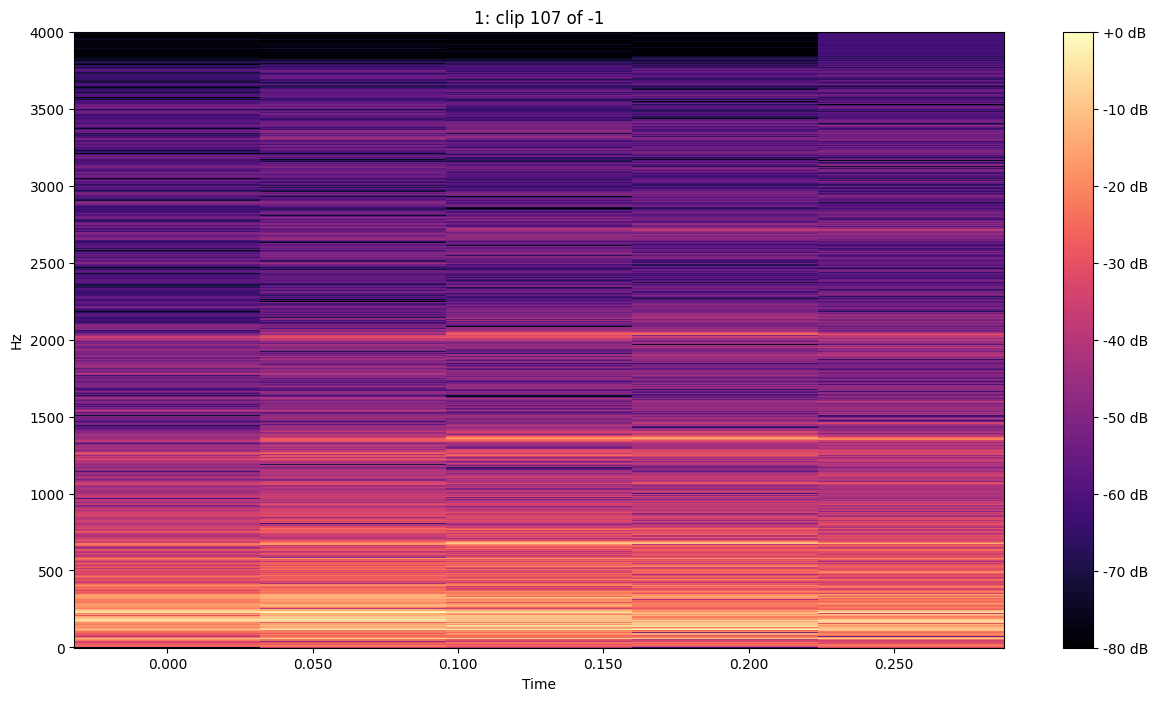

(array([-0.00076294, -0.00106812, -0.00109863, ...,  0.00778198,
         0.00842285,  0.00952148], dtype=float32),
 8000)

In [451]:
def display_audio_spec_mozz(df_mosquitoes, sample_number, fed, rate=8000):
    '''Display spectrogram and play audio for a certain clip of a mosquito species within dataframe `df_all`. This 
    example script uses indexing to retrieve results for Tanzanian cup data, but may be used for any audio in the database
    by selecting any condition from the metadata.'''
    df_match = df_mosquitoes[df_mosquitoes['fed'] == fed]
    df_class_sample = df_match[df_match['id'] == sample_number]
    signal, rate = match_file(sample_number, rate)
    D = get_fft_signal(signal)  # STFT of y
    S_db = librosa.amplitude_to_db(D, ref=np.max)
    fig, ax = plt.subplots(figsize=(15,8))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr =rate)
    ax.set(title=fed + ': clip ' + str(sample_number) + ' of ' + str(len(df_match.to_numpy())-1))
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    plt.show()
    display(Audio(signal, rate=rate))

    return signal, rate

display_audio_spec_mozz(df_mosquitoes, 107, '1')

In [452]:
classes = ['0','1']

def match_mosquito_to_audio(mosquito):
    sample_number = mosquito[0]
    signal, rate = match_file(sample_number)
    return get_fft_signal(signal)

print(match_mosquito_to_audio(df_mosquitoes.to_numpy()[0]))

[[0.00052037 0.07066966 0.04685575 0.00273575 0.10007015]
 [0.06674919 0.1319891  0.09626424 0.06543787 0.15392424]
 [0.15141182 0.25978538 0.14636734 0.0999283  0.21620736]
 ...
 [0.00065873 0.00092359 0.0007941  0.00047985 0.00341352]
 [0.00072147 0.00052909 0.00056817 0.00047654 0.0031853 ]
 [0.0006288  0.0002655  0.00027595 0.00036069 0.00307501]]


/var/folders/_f/73d70ysn2hxd43fg10gy9r3h0000gn/T/ipykernel_92078/789553557.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  return librosa.load(filename, sr=rate)


In [453]:
result_mosquitoes = []
mosquitoes = df_mosquitoes.to_numpy()
for mosquito in mosquitoes:
    sample_id = mosquito[0]
    signal = match_mosquito_to_audio(mosquito)
    data = create_data(signal, 8000, sample_id, mosquito)
    result_mosquitoes.append(data)

# convert to pandas dataframe
df = pd.DataFrame(result_mosquitoes, columns=['id', 'fed', 'gender', 'device', 'rate', 'signal'])


/var/folders/_f/73d70ysn2hxd43fg10gy9r3h0000gn/T/ipykernel_92078/789553557.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  return librosa.load(filename, sr=rate)
/Users/sannikilpelainen/Library/Python/3.10/lib/python/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1630
  warnings.warn(
/Users/sannikilpelainen/Library/Python/3.10/lib/python/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1935
  warnings.warn(


In [454]:
# create 20 frequency bins
bins = np.linspace(0, 1/1000, 20)

# transform the signal data into frequency bins
def transform_signal(signal):
    return np.histogram(signal, bins=bins)[0]

# apply the transformation to the signal data
df['transformed_signal'] = df['signal'].apply(transform_signal)

df.head()

df['transformed_signal'].to_numpy()[0]

array([ 1,  6,  8, 20,  9, 21, 25, 21, 21, 21, 19, 12, 19, 14, 14, 12, 10,
        9,  6])

In [455]:
# create new columns for each frequency bin
for i in range(19):
    df[f'bin_{i}'] = df['transformed_signal'].apply(lambda x: x[i])

# drop the transformed signal column and the signal column
df.head(400)

,id,fed,gender,device,rate,signal,transformed_signal,bin_0,bin_1,bin_2,...,bin_9,bin_10,bin_11,bin_12,bin_13,bin_14,bin_15,bin_16,bin_17,bin_18
0,107,1,Male,phone,8000,"[0.0005203698, 0.07066966, 0.046855748, 0.0027...","[1, 6, 8, 20, 9, 21, 25, 21, 21, 21, 19, 12, 1...",1,6,8,...,21,19,12,19,14,14,12,10,9,6
1,125,1,Male,phone,8000,"[0.24269421, 0.13718084, 0.00961919, 0.0176181...","[2, 3, 3, 4, 5, 5, 4, 8, 9, 10, 10, 13, 11, 4,...",2,3,3,...,10,10,13,11,4,5,5,11,9,6
2,132,1,Male,phone,8000,"[0.2205356, 0.10011688, 0.005358912, 0.0100245...","[1, 5, 16, 25, 20, 23, 20, 24, 28, 19, 20, 14,...",1,5,16,...,19,20,14,16,14,12,17,8,19,13
3,134,1,Male,phone,8000,"[0.015256981, 0.006175992, 0.0058110077, 0.048...","[1, 6, 5, 10, 12, 7, 19, 12, 7, 11, 7, 8, 9, 6...",1,6,5,...,11,7,8,9,6,9,3,8,13,13
4,146,1,Male,phone,8000,"[0.00069770677, 0.047521707, 0.0428927, 0.0227...","[7, 16, 30, 32, 28, 51, 36, 41, 28, 25, 23, 23...",7,16,30,...,25,23,23,28,20,15,21,19,14,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,222581,0,Female,telinga,8000,"[6.1738253, 11.031082, 9.735364, 4.005157, 16....","[12208, 1933, 1634, 1540, 1531, 1548, 1700, 17...",12208,1933,1634,...,1922,2045,2138,2214,2382,2479,2535,2656,2911,2873
396,222599,0,Female,telinga,8000,"[0.030309886, 0.5530081, 2.1969752, 4.6305313,...","[8092, 1412, 1217, 1167, 1182, 1314, 1389, 144...",8092,1412,1217,...,1617,1737,1853,1937,2091,2205,2295,2339,2426,2630
397,222617,0,Female,telinga,8000,"[0.65980786, 1.0264691, 1.2031001, 1.2456791, ...","[13786, 2415, 1906, 1865, 1948, 2010, 2116, 21...",13786,2415,1906,...,2518,2699,2825,2986,3333,3307,3542,3482,3853,3849
398,222602,1,Female,telinga,8000,"[0.34195933, 0.79328024, 0.18698654, 2.7880385...","[13284, 2313, 1801, 1770, 1822, 1923, 1955, 21...",13284,2313,1801,...,2371,2495,2690,2769,2959,3068,3146,3410,3422,3578


In [456]:
# create a new dataframe with only the frequency bins and fed
X = df[['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_5', 'bin_6', 'bin_7', 'bin_8', 'bin_9', 'bin_10', 'bin_11', 'bin_12', 'bin_13', 'bin_14', 'bin_15', 'bin_16', 'bin_17', 'bin_18']].copy().to_numpy()
y = df['fed'].copy().to_numpy()

In [457]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

0.75


/Users/sannikilpelainen/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


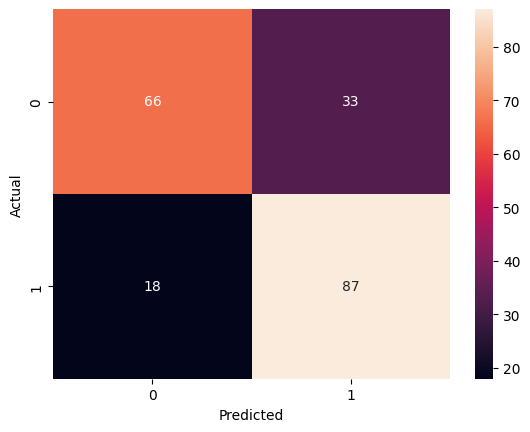

In [458]:
# fit logistic regression model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# predict on test set
y_pred = lr.predict(X_test)

# calculate accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

# plot confusion matrix
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


<Axes: >

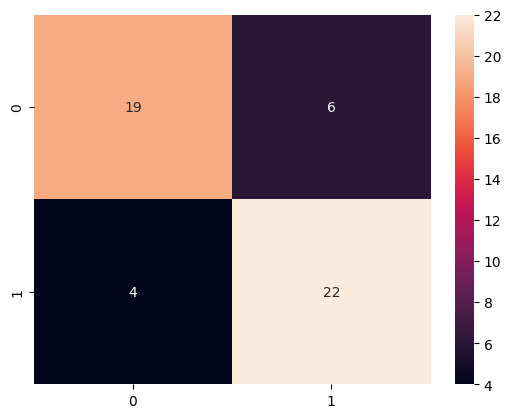

In [462]:
# Train random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

# Plot the confusion matrix
import seaborn as sns
sns.heatmap(cm, annot=True)


In [463]:
print(accuracy_score(y_test, y_pred))


0.803921568627451


0.8461538461538461


<Axes: >

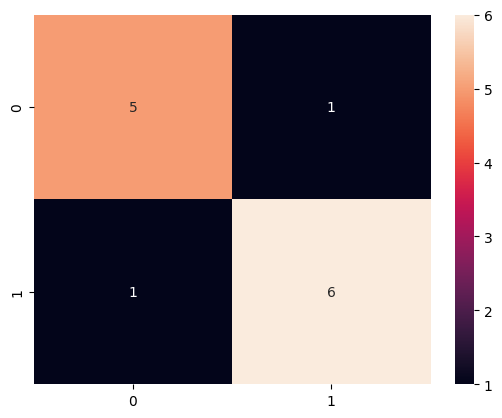

In [464]:
# split test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, random_state=42)

# Test the model on the test set
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

# Create a confusion matrix
cm2 = confusion_matrix(y_test, y_pred)
cm2

# Plot the confusion matrix
sns.heatmap(cm2, annot=True)

# Test the model on the validation set